# Data Exploration & Visualization

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

In [4]:
print(role)
print(bucket)
print(region)

arn:aws:iam::003294323742:role/service-role/AmazonSageMaker-ExecutionRole-20221228T123920
sagemaker-us-east-2-003294323742
us-east-2


In [5]:
import pandas as pd
# PyAthena imports
from pyathena import connect

In [6]:
%store -r setup_dependences_passed

In [7]:
print(setup_dependences_passed)

True


## Set up Connection to Data Source

Define the database and table holding our Amazon Customer Reviews Dataset information in Amazon Athena

In [8]:
database_name = 'dsaws'
table_name = 'amazon_reviews_parquet'

In [9]:
# Set Athena query results S3 bucket
s3_staging_dir = 's3://{}/athena/staging'.format(bucket)

# Set up PyAthena connection
conn = connect(region_name = region, s3_staging_dir= s3_staging_dir)

In [10]:
pd.read_sql("""SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name), conn)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,year,review_date,product_category
0,US,10071511,R33Z9ZDU7IXNYW,B004E10R4K,404225442,Need for Speed: Hot Pursuit,5,1,1,N,Y,"The Best Racing Game To Date, Ever.",Criterion's Burnout engine has been refined an...,2011,2011-02-07,Digital_Video_Games
1,US,26673993,R8L9R4QLLSBK6,B00452VG02,959055547,Battlefield: Bad Company 2,5,0,1,N,Y,Close to real experience game,when I start playing this game I was more than...,2011,2011-02-07,Digital_Video_Games
2,US,52520442,R1LMTM44C6K2S6,B00328HP9Q,153296559,Jojo's Fashion Show World Tour [Download],5,2,2,N,N,Fabulous,This is my favorite of all of the Jojo fashion...,2011,2011-02-07,Digital_Video_Games
3,US,50911990,R3AH462MYK3JZA,B004CYEOTI,666206014,Twisted Lands: Shadow Town,3,5,5,N,Y,Not Enough,This game could have been a real winner. The a...,2011,2011-02-07,Digital_Video_Games
4,US,33298672,R33POXLJ0B1SLO,B0045Y2D4I,168404671,Sherlock Holmes vs. Jack the Ripper,5,0,0,N,N,one of the best adventure/puzzle games ever made,"i love this game,it really made you feel you'r...",2011,2011-02-07,Digital_Video_Games


Get all the unique product categories in the table

In [11]:
# Query a list of the distinct product categories
sql_statement = """
SELECT DISTINCT product_category 
FROM {}.{}
ORDER BY product_category
""".format(database_name, table_name)

In [12]:
# Execute the query using pandas
pd.read_sql(sql_statement, conn)

,product_category
0,Apparel
1,Automotive
2,Baby
3,Beauty
4,Books
5,Camera
6,Digital_Ebook_Purchase
7,Digital_Music_Purchase
8,Digital_Software
9,Digital_Video_Download


# Data Visualization

#### Which product categories are the highest rated by average rating?

In [13]:
highest_rating_query = """
SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM {}.{}
GROUP BY product_category
ORDER BY avg_star_rating 
""".format(database_name, table_name)

highest_rating_df = pd.read_sql(highest_rating_query, conn)

In [14]:
highest_rating_df.head()

,product_category,avg_star_rating
0,Digital_Software,3.539330
1,Software,3.567035
2,Major Appliances,3.716185
3,Mobile_Electronics,3.763163
4,Digital_Video_Games,3.853126


Text(0, 0.5, 'Product Category')

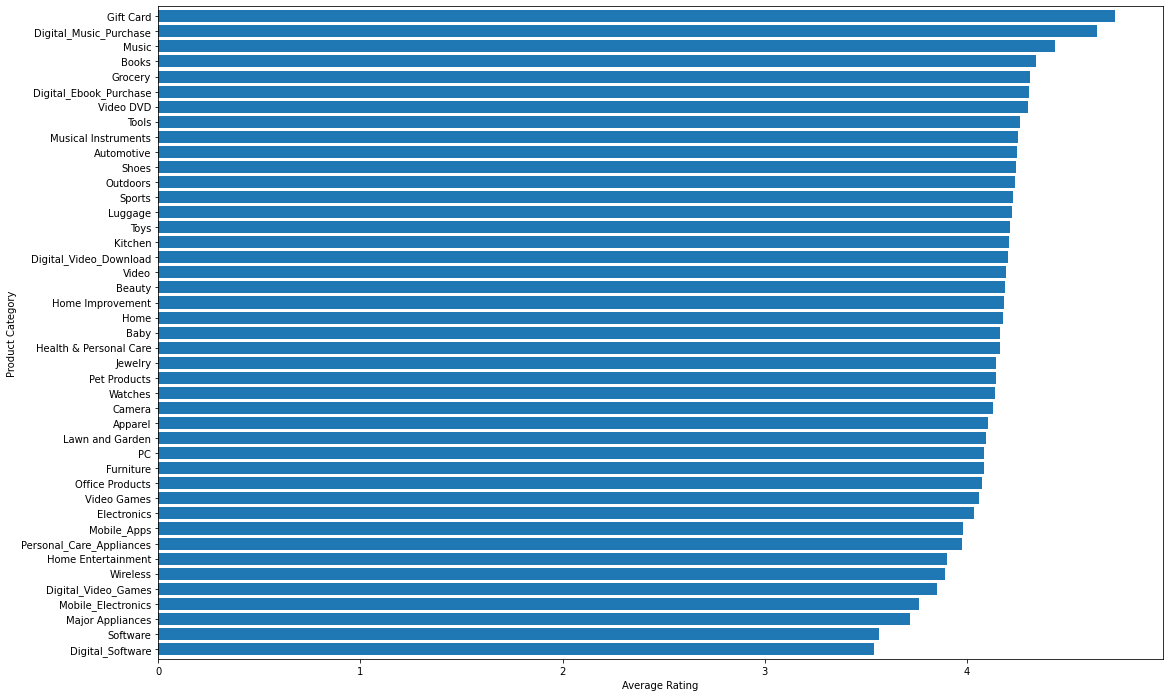

In [15]:
highest_rating_df.plot.barh(x = 'product_category', y = 'avg_star_rating', legend = None, width = 0.8)
plt.gcf().set_size_inches(18,12)
plt.xlabel('Average Rating')
plt.ylabel('Product Category')


From this horizontal bar plot, we can see that the Gift Care Product Category is the highest-rated product category.

#### Which product categories have the most reviews

In [16]:
most_reviews_query = """
SELECT product_category, COUNT(star_rating) AS number_of_reviews
FROM {}.{}
GROUP BY product_category
ORDER BY number_of_reviews
""".format(database_name, table_name)

most_reviews_df = pd.read_sql(most_reviews_query, conn)
most_reviews_df.head()

,product_category,number_of_reviews
0,Personal_Care_Appliances,85981
1,Major Appliances,96901
2,Digital_Software,102084
3,Mobile_Electronics,104975
4,Digital_Video_Games,145431


Text(0, 0.5, 'Product Category')

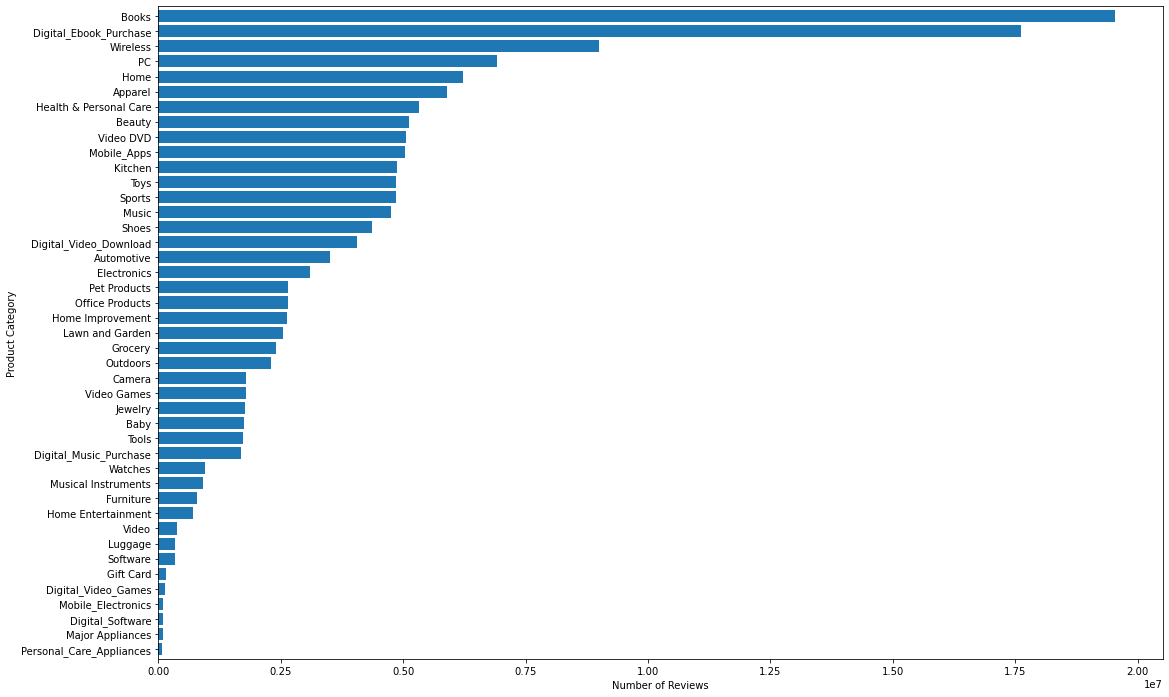

In [17]:
most_reviews_df.plot.barh(x = 'product_category', y = 'number_of_reviews', legend = None, width = 0.8)
plt.gcf().set_size_inches(18,12)
plt.xlabel('Number of Reviews')
plt.ylabel('Product Category')

From this horizontal bar plot, we can see that the Books product category has received the most reviews which makes sense because Amazon initially started off as a book store. Personal Care Appliances has received the least amount of reviews. This could be because they were introduced into the marketplace later than other product categories.

#### When did each product category become available in the Amazon catalog?

In [18]:
category_first_year_query = """
SELECT product_category, MIN(year) AS first_year
FROM {}.{}
GROUP BY product_category
ORDER BY first_year
""".format(database_name, table_name)

category_first_year_df = pd.read_sql(category_first_year_query, conn)
category_first_year_df.head()

,product_category,first_year
0,Video,1995
1,Music,1995
2,Books,1995
3,Video DVD,1996
4,Sports,1997


Text(0.5, 0, 'Year')

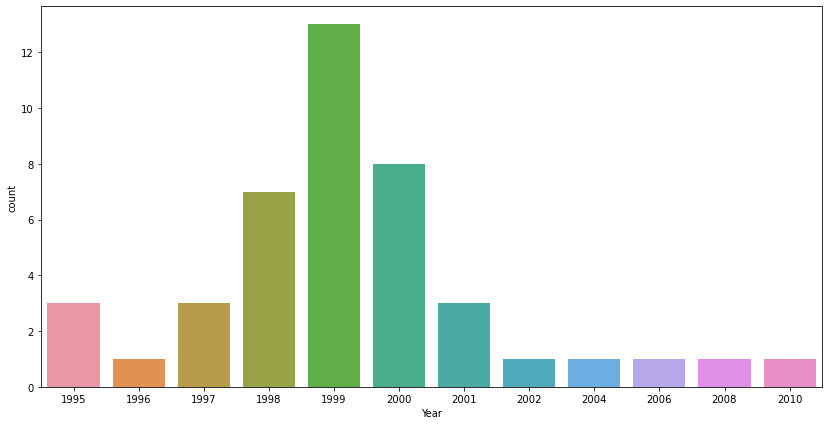

In [20]:
fig = plt.figure(figsize = (14,7))
sns.countplot(data = category_first_year_df, x = 'first_year')
plt.xlabel('Year')

From this countplot, we can see that a lot of product categories (13) received their first reviews in 1999. 

#### Number of reviews per star ratings (1-5)

In [27]:
num_per_rating_query = """
SELECT star_rating, COUNT(*) AS number_of_reviews
FROM {}.{}
GROUP BY star_rating
ORDER BY star_rating ASC
""".format(database_name, table_name)

num_per_rating_df = pd.read_sql(num_per_rating_query, conn)
num_per_rating_df.head()

,star_rating,number_of_reviews
0,1,12099639
1,2,7304430
2,3,12133927
3,4,26223470
4,5,93200812


Text(0, 0.5, 'Number of Reviews')

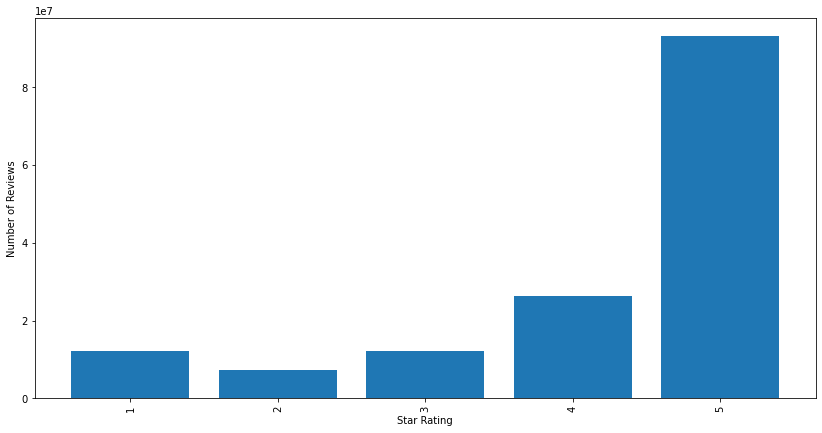

In [28]:
num_per_rating_df.plot.bar(x = 'star_rating', y = 'number_of_reviews', legend = None, width = 0.8)
plt.gcf().set_size_inches(14,7)
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')

Majority of reviews in the Amazon Customer Reviews dataset are 5 star reviews.

#### What is the breakdown of star ratings (1-5) per product category?

In [22]:
rating_breakdown_query = """
SELECT product_category, star_rating, COUNT(*) as number_of_reviews
FROM {}.{}
GROUP BY product_category, star_rating
ORDER BY product_category ASC, star_rating DESC, number_of_reviews
""".format(database_name, table_name)

rating_breakdown_df = pd.read_sql(rating_breakdown_query, conn)
rating_breakdown_df.head()

,product_category,star_rating,number_of_reviews
0,Apparel,5,3320566
1,Apparel,4,1147237
2,Apparel,3,623471
3,Apparel,2,369601
4,Apparel,1,445458


In [41]:
product_categories = rating_breakdown_df.product_category.unique().tolist()

star_rating_distribution = {}
for category in product_categories:
    star_rating_distribution[category] = rating_breakdown_df[
        rating_breakdown_df['product_category'] == category].number_of_reviews.values.tolist()

In [43]:
df_distribution =pd.DataFrame(star_rating_distribution).transpose().apply(
        lambda num_reviews: num_reviews/sum(num_reviews)*100, axis = 1)

df_distribution.columns = ['5 Star', '4 Star', '3 Star', '2 Star', '1 Star']
df_distribution.head()

,5 Star,4 Star,3 Star,2 Star,1 Star
Apparel,56.220433,19.423846,10.555974,6.257707,7.542040
Automotive,65.456471,14.983604,6.824750,4.203967,8.531208
Baby,61.055306,16.393676,8.553384,5.759265,8.238369
Beauty,63.626300,14.493401,7.787881,5.161185,8.931232
Books,65.914726,17.164751,7.437722,4.137230,5.345571


<Figure size 1008x504 with 0 Axes>

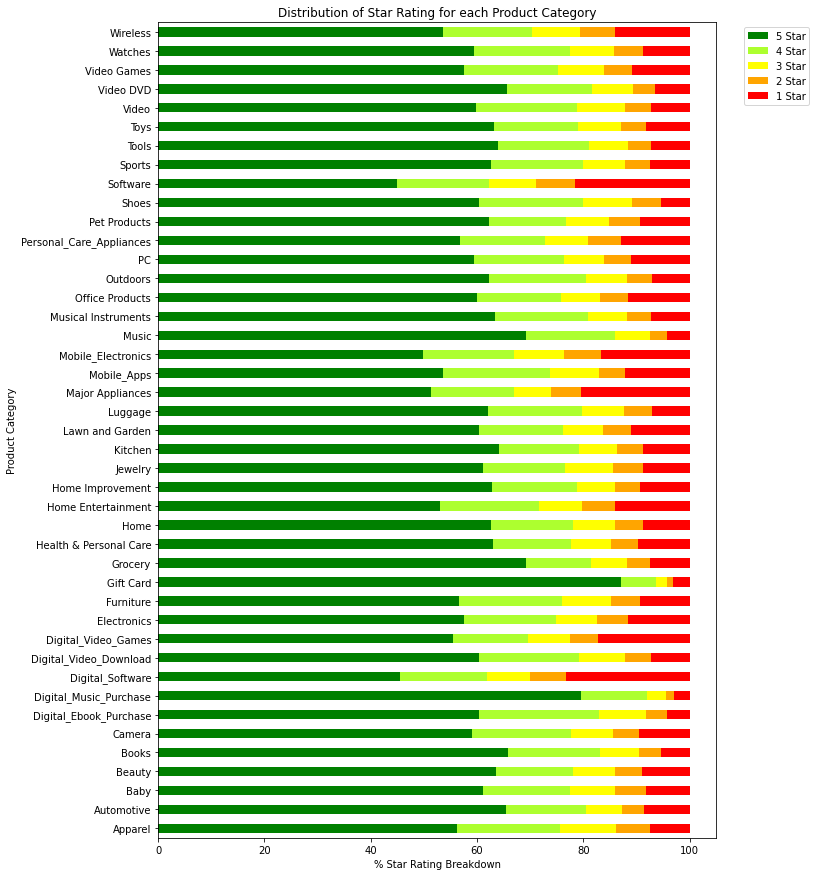

In [49]:
# Plot the distributions of star rating for each product category
fig = plt.figure(figsize = (14,7))

df_distribution.plot(kind = 'barh',
                     stacked = True,
                     color = ['green', 'greenyellow', 'yellow','orange','red' ])

plt.title('Distribution of Star Rating for each Product Category')
plt.legend(labels = ['5 Star', '4 Star', '3 Star', '2 Star', '1 Star'],
          loc = 'upper left',
          bbox_to_anchor = (1.04,1))

plt.xlabel('% Star Rating Breakdown')
plt.ylabel('Product Category')
plt.gcf().set_size_inches(10,15)
plt.show()

We can see that 5 star and 4 star ratings make up a large proportion of star ratings for each product category.

#### How have the ratings changed over time? 

In [52]:
rating_change_query = """
SELECT year, AVG(star_rating) AS average_rating
FROM {}.{}
GROUP BY year
ORDER BY year ASC
""".format(database_name, table_name)

rating_change_df = pd.read_sql(rating_change_query, conn)
rating_change_df.head()

,year,average_rating
0,1995,4.616915
1,1996,4.600341
2,1997,4.434437
3,1998,4.360676
4,1999,4.281893


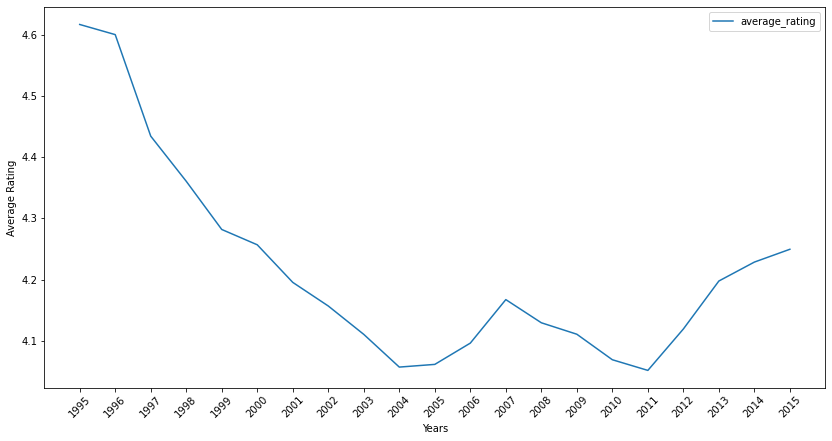

In [62]:
plt.gcf().set_size_inches(14,7)
ax = plt.gca()
ax.set_xticks(rating_change_df['year'].unique())


rating_change_df.plot(kind = 'line', x = 'year', y = 'average_rating', ax = ax)
plt.xlabel('Years')
plt.ylabel('Average Rating')
plt.xticks(rotation = 45)

plt.show()

Star Ratings started off very high and they began to trend downwards. However, after 2011 star ratings are trending upwards.

#### How have the number of ratings changed over time?

In [63]:
num_reviews_change_query = """
SELECT year, COUNT(*) AS number_of_reviews
FROM {}.{}
GROUP BY year
ORDER BY year ASC
""".format(database_name, table_name)

num_reviews_change_df = pd.read_sql(num_reviews_change_query, conn)
num_reviews_change_df.head()

,year,number_of_reviews
0,1995,201
1,1996,4689
2,1997,36850
3,1998,162783
4,1999,435016


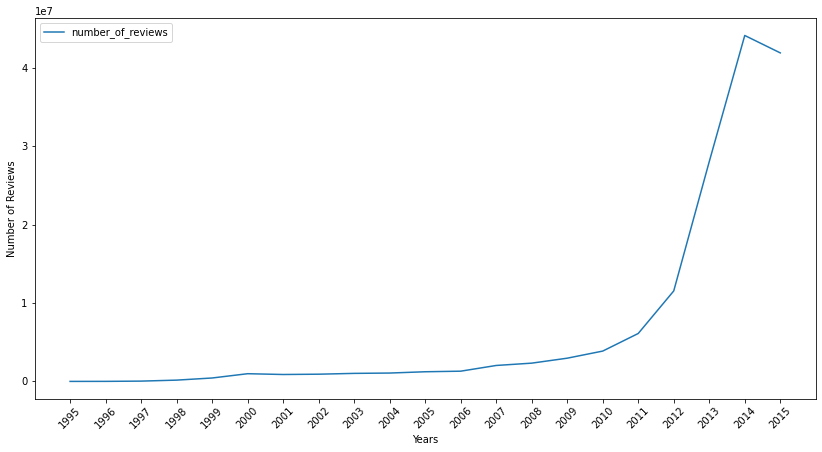

In [64]:
plt.gcf().set_size_inches(14,7)
ax = plt.gca()
ax.set_xticks(num_reviews_change_df['year'].unique())


num_reviews_change_df.plot(kind = 'line', x = 'year', y = 'number_of_reviews', ax = ax)
plt.xlabel('Years')
plt.ylabel('Number of Reviews')
plt.xticks(rotation = 45)

plt.show()

The number of reviews have exponentially increased starting from the year 2011.

#### Which Star Ratings (1-5) are the most helpful?

In [65]:
helpfulness_query = """
SELECT star_rating, AVG(helpful_votes) AS average_helpfulness
FROM {}.{}
GROUP BY star_rating
ORDER BY star_rating DESC
""".format(database_name, table_name)

helpfulness_df = pd.read_sql(helpfulness_query, conn)
helpfulness_df.head()

,star_rating,average_helpfulness
0,5,1.672698
1,4,1.678697
2,3,2.048090
3,2,2.506635
4,1,3.684641


Text(0, 0.5, 'Average Helpfulness')

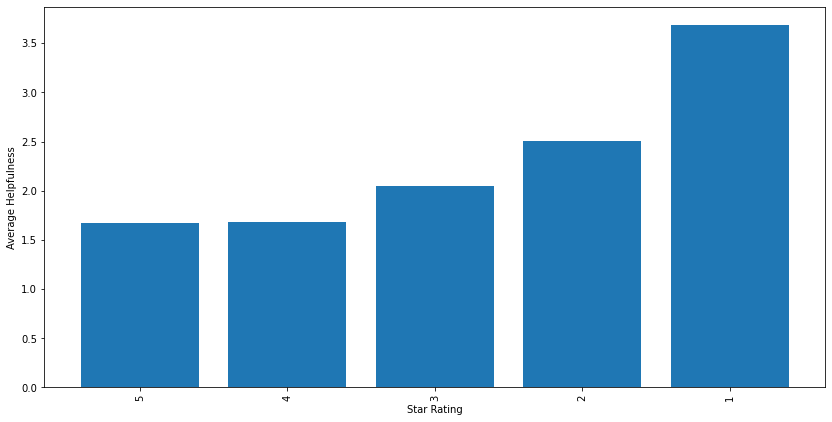

In [66]:
helpfulness_df.plot.bar(x = 'star_rating', y = 'average_helpfulness', legend = None, width = 0.8)
plt.gcf().set_size_inches(14,7)
plt.xlabel('Star Rating')
plt.ylabel('Average Helpfulness')

Customers found that negative reivews are more helpful than positive reviews.

#### Which Products have the most helpful reviews?


In [67]:
product_helpful_query = """
SELECT product_title, helpful_votes
FROM {}.{}
ORDER BY helpful_votes DESC
LIMIT 10
""".format(database_name, table_name)

product_helpful_df = pd.read_sql(product_helpful_query, conn)
product_helpful_df

,product_title,helpful_votes
0,Kindle: Amazon's Original Wireless Reading Dev...,47524
1,"BIC Cristal For Her Ball Pen, 1.0mm, Black, 16...",41393
2,The Mountain Kids 100% Cotton Three Wolf Moon ...,41278
3,"Kindle Keyboard 3G, Free 3G + Wi-Fi, 6"" E Ink ...",31924
4,"Kindle Fire HD 7"", Dolby Audio, Dual-Band Wi-Fi",31417
5,Kindle Fire (Previous Generation - 1st),28611
6,Fifty Shades of Grey: Book One of the Fifty Sh...,27550
7,Wheelmate Laptop Steering Wheel Desk,26132
8,"Kindle Wireless Reading Device (6"" Display, U....",24714
9,"Tuscan Dairy Whole Vitamin D Milk, Gallon, 128 oz",23755


#### Customers who reviewed one product more than once

Customers sometimes abuse the rating system by constantly reviewing a product multiple times giving the product a false rating. We can query which users have given multiple ratings to the same product.

In [68]:
customer_product_query = """
SELECT customer_id, product_title, AVG(star_rating) AS average_rating, COUNT(*) AS number_of_reviews
FROM {}.{}
GROUP BY customer_id, product_title
HAVING COUNT(*) > 1
ORDER BY number_of_reviews DESC
""".format(database_name, table_name)

customer_product_df = pd.read_sql(customer_product_query, conn)
customer_product_df.head()

,customer_id,product_title,average_rating,number_of_reviews
0,38118182,Pearl Harbor,4.230769,130
1,33132919,Shania Twain - Up (Live in Chicago),5.000000,110
2,52895956,Frankenstein,3.020408,98
3,43622173,Sinner,4.975610,82
4,32330663,Reprise,5.000000,82


#### Distribution of Number of Words in Reviews

In [ ]:
num_words_query = """
SELECT CARDINALITY(SPLIT(review_body, ' ')) AS number_of_words
FROM {}.{}
""".format(database_name, table_name)

num_words_df = pd.read_sql(num_words_query, conn)
num_words_df.head()